In [78]:
import SITSpinOneMFT as sit
import numpy as np 
from scipy import integrate as intg
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as mclr


In [7]:
Lx = 4
Ly = 5

nEc = 10
Ecs = np.linspace(10.,1.,nEc)
deltaEcs = 0.12*sit.rng.random((Lx,Ly))
Ej = 1. 

prev_wf = sit.initialize_Mott(Lx,Ly)

energies = np.zeros(nEc)
psis = np.zeros(nEc,dtype=complex)

for i in range(nEc):
    Ec = Ecs[i]*np.ones((Lx,Ly))+ deltaEcs
    t0 = time.time()
    gs, energies[i] = sit.find_GS(Lx,Ly,Ec,Ej,prev_wf)
    t1 = time.time()
    print(t1-t0,"s")

    prev_wf = gs

    psis[i] = sit.SF_OP(gs)


77.10723400115967 s
80.93410611152649 s
75.27226281166077 s
67.3629560470581 s
65.41951107978821 s
121.31440091133118 s
138.6532542705536 s
65.02693915367126 s
181.1623351573944 s
113.37088084220886 s


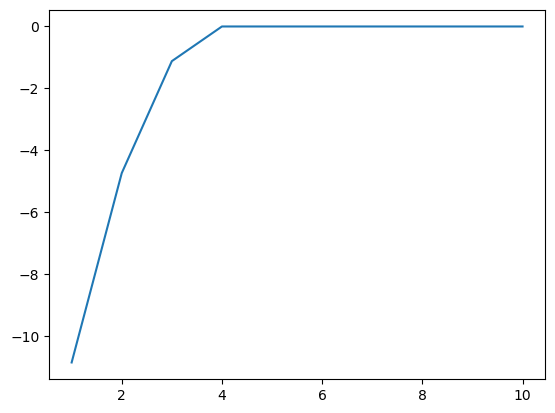

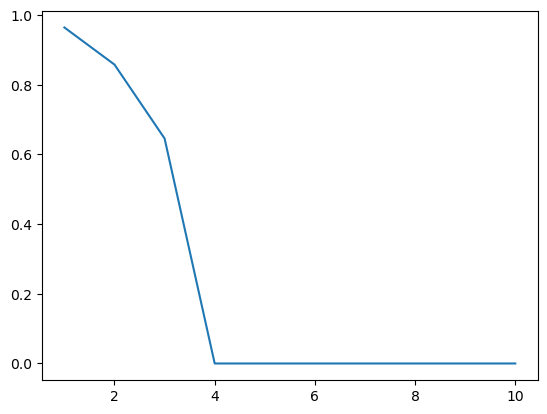

In [8]:
plt.plot(Ecs,energies)
plt.show()
plt.plot(Ecs,np.abs(psis))
plt.show()

In [73]:
### This is the equation of motion function 
### Accepts the flattened wavefunction as an argument
def eom(t,X,Lx,Ly,Ec,Ej):
    ### First we unflatten X 
    wf = X.reshape((3,Lx,Ly))
    
    ### We now compute the equation of motion
    ### First term is the local charging energy
    ### This is -i Ec[x,y] Sz^2 psi[x,y]
    
    charging_eom = -1.j*np.tensordot( (sit.spin_one_matrices[3])@(sit.spin_one_matrices[3]), wf,axes=(1,0))*Ec
    
    dXdt = charging_eom.flatten()

    ### Now we have the Josephson contributions
    ### These are obtained as S.MF
    ### Where MF = -0.5*Ej *( m[x+1,y] + m[x-1,y]+m[x,y+1]+m[x,y-1]) 

    m = sit.magnetization(wf)

    curie_weiss = -0.5*Ej*( np.roll(m,shift=[0,1,0],axis=[0,1,2]) + np.roll(m,shift=[0,-1,0],axis=[0,1,2])+np.roll(m,shift=[0,0,1],axis=[0,1,2]) + np.roll(m,shift=[0,0,-1],axis=[0,1,2]))
    
    josephson_eom = -1.j*( np.tensordot(sit.spin_one_matrices[1],wf,axes=[1,0]) * curie_weiss[1,...] + np.tensordot(sit.spin_one_matrices[2] , wf,axes=[1,0])*curie_weiss[2,...] )

    dXdt += josephson_eom.flatten()
                 
    return dXdt 


In [101]:
wf0 = prev_wf.flatten()
t0 = 0.
tf = 20.
Ec = Ecs[-1] + deltaEcs
Ej = 1.


In [102]:
sol = intg.solve_ivp(eom,(t0,tf),wf0,args=(Lx,Ly,Ec,Ej))

In [103]:
sol.y.shape

(60, 34)

In [104]:
wfs = sol.y.reshape((3,Lx,Ly,sol.y.shape[-1]))

In [105]:
wfs.shape

(3, 4, 5, 34)

In [106]:
m_vs_t = np.array( [ sit.magnetization(wfs[...,j]) for j in range(len(sol.t))])

In [107]:
c2_vs_t = np.array( [ sit.charge_squared(wfs[...,j]) for j in range(len(sol.t))])

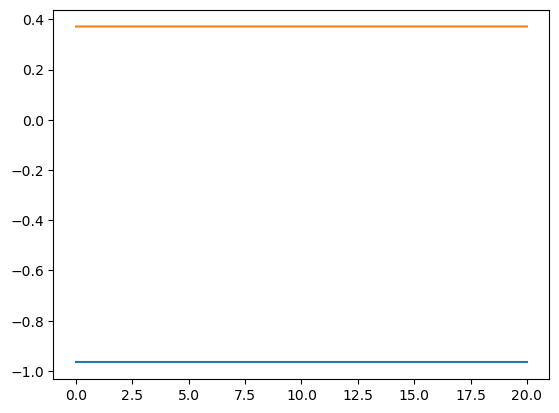

In [108]:
plt.plot(sol.t,m_vs_t[:,1,1,4])
plt.plot(sol.t,c2_vs_t[:,1,4])
plt.show()